# $U(1)$ Gauge Model using L2HMC in graph mode

--------------------------------------------------------------------
### TODO:
* [ ] Look at performance on Cooley (longer training runs).
* [ ] Fit observables to Eq. \ref{eq:therm_time} to determine the thermalization time $\tau$.

\begin{equation} 
f(t) \equiv A \exp^{-t / \tau}+ \,\, B
\label{eq:therm_time}
\end{equation}
* [ ] Look at defining a distance metric as the difference in topological charge between two samples and see what effect adding this as an additional term to the loss function has on the models' ability to tunnel between topological sectors.

--------------------------------------------------------------------

In [1]:
import os
import sys
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.special import i0, i1

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import utils.gauge_model_helpers as helpers
from utils.data_utils import (
    calc_avg_vals_errors, block_resampling, jackknife_err
)
from gauge_model import GaugeModel

tfe = tf.contrib.eager
%autoreload 2
%matplotlib notebook

## Define parameters

In [2]:
x = np.arange(-5, 5, 0.05)
y = np.mod(x, 2*np.pi)

In [5]:
from lattice.lattice import project_angle

In [6]:
y1 = project_angle(x)

In [8]:
def project_angle(x):
    return x - 2 * np.pi * np.floor((x + np.pi) / (2 * np.pi))

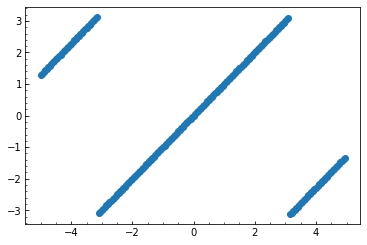

In [9]:
y1 = project_angle(x)
fig, ax = plt.subplots()
ax.plot(x, y1, marker='o', ls='')
plt.show()

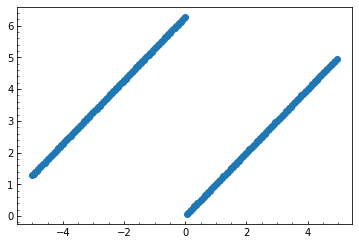

In [4]:
fig, ax = plt.subplots()
ax.plot(x, y, marker='o', ls='')
plt.show()

In [2]:
tf.reset_default_graph()

params = {
#--------------------- Lattice parameters ----------------------------
    'time_size': 8,
    'space_size': 8,
    'link_type': 'U1',
    'dim': 2,
    'num_samples': 50,
    'rand': False,
#--------------------- Leapfrog parameters ---------------------------
    'num_steps': 3,
    'eps': 0.25,
    'loss_scale': 0.1,
    #'loss_eps': 1e-4,
#--------------------- Learning rate parameters ----------------------
    'learning_rate_init': 1e-3,
    'learning_rate_decay_steps': 1000,
    'learning_rate_decay_rate': 0.98,
#--------------------- Annealing rate parameters ---------------------
    'annealing': True,
    #'annealing_steps': 1,
    #'annealing_factor': 0.9999,
    #'beta': 3.,
    'beta_init': 2.,
    'beta_final': 4.,
#--------------------- Training parameters ---------------------------
    'train_steps': 10000,
    'save_steps': 1000,
    'logging_steps': 50,
    'print_steps': 1,
    'training_samples_steps': 10,
    'training_samples_length': 100,
#--------------------- Model parameters ------------------------------
    'network_arch': 'conv3D',
    'data_format': 'channels_last',
    'hmc': False,
    'eps_trainable': True,
    'metric': 'cos_diff',
    'aux': True,
    'plaq_loss': False,
    'summaries': True,
    'clip_grads': False,
    'clip_value': None,
    'using_hvd': False
}

## Create model

In [3]:
os.environ["KMP_BLOCKTIME"] = str(0)
os.environ["KMP_SETTINGS"] = str(1)
os.environ["KMP_AFFINITY"] = "granularity=fine,verbose,compact,1,0"
os.environ["OMP_NUM_THREADS"] = str(2)
config = tf.ConfigProto()
tf.reset_default_graph()

In [4]:
# 15.7 s to create for 8x8, num_samples=100, num_steps=1
# 15.2 s to create for 8x8, num_samples=10, num_steps=3
model = GaugeModel(params=params, 
                   config=config,
                   sess=None,
                   log_dir=None,
                   restore=False)

#save_params_to_pkl_file(params, model.info_dir)

Creating directory for new run: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_333/
Creating directory: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_333/eval_info
Creating directory: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_333/eval_info/samples
Creating directory: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_333/eval_info/training
Creating directory: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_333/eval_info/training/samples
Creating directory: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_333/observables
Creating directory: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_333/observables/training
time_size: 8
space_size: 8
link_type: U1
dim: 2
num_samples: 50
rand: False
num_steps: 3
eps: 0.25
loss_scale: 0.1
learning_rate_init: 0.001
learning_rate_decay_steps: 1000
learning_rate_decay_rate: 0.98
annealing: True
beta_init: 2.0
beta_final: 4.0
train_steps: 10000
save_steps: 1000
logging_steps: 50
print_steps: 1
training_samples_steps: 10
training_samples_length: 100
network

TypeError: super(type, obj): obj must be an instance or subtype of type

In [6]:
import utils.file_io as io
io.save_params_to_pkl_file(params, model.info_dir)

Saving params to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_310/run_info/parameters.pkl.


In [7]:
# ~ 0.3xx s / step for 8x8, num_samples=100, num_steps=1
# ~ 1.3x s / step for 8x8, num_samples=100, num_steps=5
# ~ 0.97x s / step for 8x8, num_samples=128, num_steps=3
# ~ 0.75x s / step for 8x8, num_samples=20, num_steps=5
# ~ 1.5x s / step for 8x8, num_samples=20, num_steps=10
model.train(model.train_steps)

-----------------------------------------------------------------------------------------------------------------
    STEP       LOSS     t/STEP   ACCEPT %    EPS       BETA     ACTION     PLAQ    PLAQ INF     dQ        LR    
-----------------------------------------------------------------------------------------------------------------


AlreadyExistsError: Resource __per_step_3/loss/grads/gradients/loss/z_update/apply_transition/transition_forward/transition_kernel_forward/while/forward_lf/update_momentum_forward/update_momentum_forward/scale/ReadVariableOp/Enter_grad/ArithmeticOptimizer/AddOpsRewrite_Add/tmp_var/N10tensorflow19TemporaryVariableOp6TmpVarE
	 [[{{node loss/grads/gradients/loss/z_update/apply_transition/transition_forward/transition_kernel_forward/while/forward_lf/update_momentum_forward/update_momentum_forward/scale/ReadVariableOp/Enter_grad/ArithmeticOptimizer/AddOpsRewrite_Add/tmp_var}} = TemporaryVariable[dtype=DT_FLOAT, shape=[], var_name="loss/grads...dd/tmp_var", _device="/job:localhost/replica:0/task:0/device:CPU:0"](^loss/grads/gradients/loss/z_update/apply_transition/transition_forward/transition_kernel_forward/while/forward_lf/update_momentum_forward_1/update_momentum_forward/momentum/mul_1_grad/Mul_1)]]

In [8]:
%debug

> /Users/saforem2/.local/lib/python3.6/site-packages/tensorflow/python/client/session.py(1348)_do_call()
   1346           pass
   1347       message = error_interpolation.interpolate(message, self._graph)
-> 1348       raise type(e)(node_def, op, message)
   1349 
   1350   def _extend_graph(self):

ipdb> up
> /Users/saforem2/.local/lib/python3.6/site-packages/tensorflow/python/client/session.py(1328)_do_run()
   1326     if handle is None:
   1327       return self._do_call(_run_fn, feeds, fetches, targets, options,
-> 1328                            run_metadata)
   1329     else:
   1330       return self._do_call(_prun_fn, handle, feeds, fetches)

ipdb> up
> /Users/saforem2/.local/lib/python3.6/site-packages/tensorflow/python/client/session.py(1152)_run()
   1150     if final_fetches or final_targets or (handle and feed_dict_tensor):
   1151       results = self._do_run(handle, final_targets, final_fetches,
-> 1152                              feed_dict_tensor, options, run_metada

In [9]:
%debug

> /Users/saforem2/ANL/l2hmc/l2hmc/gauge_model.py(1640)_save_run_info()
   1638 
   1639         suscept_stats_strings = {
-> 1640             suscept_k1: f'{q_avg:.4g} +/- {q_err:.4g}',
   1641             suscept_k2: f'{q2_avg:.4g} +/- {q2_err:.4g}\n',
   1642             _est_key: {}

ipdb> suscept_k1
'  \navg. over all 50 samples < Q >'
ipdb> f'{q_avg:.4g} +/- {q_err:.4g}'
*** TypeError: unsupported format string passed to numpy.ndarray.__format__
ipdb> q_avg
0.22466667
ipdb> q_err
array([0.02473327, 0.        , 0.01562497, 0.04149045, 0.04857521,
       0.        , 0.06713315, 0.04753606, 0.        , 0.05294754,
       0.        , 0.04174048, 0.        , 0.        , 0.04747764,
       0.        , 0.04174049, 0.01902752, 0.028389  , 0.        ,
       0.03841788, 0.05298679, 0.        , 0.        , 0.02838899,
       0.03179991, 0.04907242, 0.05298679, 0.        , 0.        ,
       0.02838907, 0.04149047, 0.        , 0.0111111 , 0.03603299,
       0.05288198, 0.06169558, 0.03471943

ipdb> l
   1801     def _get_run_files(self, *_args):
   1802         """Create dir and files for storing observables from `self.run`."""
   1803         run_steps, current_step, beta, _ = _args
   1804 
   1805         observables_dir = os.path.join(self.eval_dir, 'observables')
   1806         io.check_else_make_dir(observables_dir)
   1807 
   1808         if current_step is None:                     # running AFTER training
   1809             obs_dir = os.path.join(observables_dir,
   1810                                    f'steps_{run_steps}_beta_{beta}')
   1811             io.check_else_make_dir(obs_dir)

ipdb> actions_avg
11.446076
ipdb> charges_arr.shape
(90, 50)
ipdb> sem(charges_arr)
array([0.02473327, 0.        , 0.01562497, 0.04149045, 0.04857521,
       0.        , 0.06713315, 0.04753606, 0.        , 0.05294754,
       0.        , 0.04174048, 0.        , 0.        , 0.04747764,
       0.        , 0.04174049, 0.01902752, 0.028389  , 0.        ,
       0.03841788, 0.05298

In [ ]:
betas = [3., 4.]
for beta in betas:
    model.run(50000, beta=beta)

In [ ]:
tun_events_keys = np.array(list(model.tunn_events_dict.keys()))
tun_events_vals = np.array(list(model.tunn_events_dict.values()))

In [ ]:
len(tun_events_vals)

In [ ]:
fig, ax = plt.subplots()
ax.plot(tun_events_vals, marker='.', fillstyle='none', ls='')
ax.set_xlabel('Training step', fontsize=14)
ax.set_ylabel('Number of events', fontsize=14)
title_str = (f'Number of tunneling events vs. '
             f'training step for {model.num_samples} samples')
ax.set_title(title_str, fontsize=16)
out_file = os.path.join(model.figs_dir, 'tunneling_events_vs_training_step.png')
print(f"Saving figure to: {out_file}.")
plt.savefig(out_file, dpi=400, bbox_inches='tight')

In [ ]:
tun_events_keys[:10, 1]

In [ ]:
steps = tun_events_keys[:, 0]
betas = tun_events_keys[:, 1]

In [ ]:
fig = plt.figure()
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

ax1.plot(steps, tun_events_vals / model.num_samples, 
         marker='.', fillstyle='none', ls='')
ax1.set_xlabel('Training step', fontsize=14)
ax2.set_xlabel('Beta', fontsize=16)
ax1.set_ylabel('# of tunneling events', fontsize=14)
#ax1.set_title(title_str, fontsize=16)

ax1.get_shared_x_axes().join(ax1, ax2)
ax1.set_xticklabels([])
ax2.autoscale() ## call autoscale if needed

In [ ]:
obs, stats = model.run(1000, beta=3.)

In [ ]:
obs, stats = model.run(100, beta=3.)

In [ ]:
model.tunn_ev

In [ ]:
observables = []
stats = []
betas = [3., 4.]
steps = [5e3, 1e4, 5e4]
for step in steps:
    for beta in betas:
        obs, stats = model.run(step, beta=beta)
        

In [ ]:
dir_strings = ('steps_50000_beta_4.0', 'steps_50000_beta_3.0')
obs_dirs = (os.path.join(model.eval_dir, 'observables', dir_strings[0]),
            os.path.join(model.eval_dir, 'observables', dir_strings[1]))
samples_history_files = (
    os.path.join('samples', 'samples_history_' + dir_strings[0] + '.npy'),
    os.path.join('samples', 'samples_history_' + dir_strings[1] + '.npy')
)
actions_files = (
    os.path.join(obs_dirs[0], 'actions_' + dir_strings[0] + '.pkl'),
    os.path.join(obs_dirs[1], 'actions_' + dir_strings[1] + '.pkl')
)
plaqs_files = (
    os.path.join(obs_dirs[0], 'plaqs_' + dir_strings[0] + '.pkl'),
    os.path.join(obs_dirs[1], 'plaqs_' + dir_strings[1] + '.pkl')
)
charges_files = (
    os.path.join(obs_dirs[0], 'charges_' + dir_strings[0] + '.pkl'),
    os.path.join(obs_dirs[1], 'charges_' + dir_strings[1] + '.pkl'))
tunn_events_files = (
    os.path.join(obs_dirs[0], 'tunn_events_' + dir_strings[0] + '.pkl'),
    os.path.join(obs_dirs[1], 'tunn_events_' + dir_strings[1] + '.pkl')
)

In [ ]:
import pickle

samples = []
for f in samples_files:
    samples.append(np.load(f))
actions = []
for f in actions_files:
    with open(f, 'rb') as ff:
        actions.append(pickle.load(ff))
plaqs = []
for f in plaqs_files:
    with open(f, 'rb') as ff:
        plaqs.append(pickle.load(ff))
charges = []
for f in charges_files:
    with open(f, 'rb') as ff:
        charges.append(pickle.load(ff))
tunn_events = []
for f in tunn_events_files:
    with open(f, 'rb') as ff:
        tunn_events.append(pickle.load(ff))

In [ ]:
samples = []
for f in samples_history_files:
    samples.append(np.load(f))

In [ ]:
 
tunn_events = []
for f in tunn_events_files:
    with open(f, 'rb') as ff:
        tunn_events.append(pickle.load(ff))

In [ ]:
samples = []
for f in samples_files:
    with open(f, 'rb') as ff:
        samples.append(pickle.load(ff))
tunn_events = []
for f in tunn_events_files:
    with open(f, 'rb') as ff:
        tunn_events.append(pickle.load(ff))

In [ ]:
model.run(100, beta=3.)

In [ ]:
model.run(500, beta=3.)

In [ ]:
model.run(1000, beta=4.)

In [ ]:
model.run(50000, beta=4.)

In [ ]:
model.run(50000, beta=4.)

In [ ]:
%debug

In [ ]:
model.run(50000, beta=model.beta_final)

In [ ]:
import pickle
with open(model.files['samples_pkl_file'], 'rb') as f:
    samples_init = pickle.load(f)
beta_init = model.update_beta(model.data['step'])
beta_init
model.data['learning_rate']
model.data['step']

In [ ]:
model.run(50000, beta=3.)

In [ ]:
model.run(50000, beta=4.)

In [ ]:
model.run(50000, beta=3.5)

In [ ]:
model.run(50000, beta=model.beta_final)

In [ ]:
#model.train(model.train_steps, samples_init=samples_init, beta_init=beta_init, 
#            pre_train=False, trace=False)

In [ ]:
model.run(20000, beta=model.beta_final)

In [ ]:
model.run(50000, beta=model.beta_final)

In [ ]:
# 37m 39s for 8x8 with num_steps=1 using slow _total_action method
model.run(50000, beta=3.)

In [ ]:
model.run(20000, beta=3.)

In [ ]:
#betas = [2., 4.]
betas = [model.beta_final]

In [ ]:
run_steps = [500, 1000, 5000, 10000]#, 20000]#, 50000]#, 6000#, 10000]

In [ ]:
# for 8x8 lattice, run 20000 eval steps in ~14m 20s
# for 8x8 lattice, run 30000 eval steps in ~21m 31s
# for 8x8 lattice, run 50000 eval steps in ~40m 12s
for beta in betas:
    for steps in run_steps:
        model.run(steps, beta=beta)

In [ ]:
model.sess.run(model.dynamics.eps)

In [ ]:
model.sess.run(tf.log(model.dynamics.eps))

In [ ]:
model.run(20000, beta=model.beta_final)

In [ ]:
model.run(30000, beta=model.beta_final)

In [ ]:
model.dynamics.momentum_fn.summary()

In [ ]:
model.run(20000)

In [ ]:
model.run(30000)

In [ ]:
model.run(50000)

In [ ]:
for step in run_steps:
    model.run(step, beta=2.)

In [ ]:
model.run(10000, beta=2.)

In [ ]:
model.run(40000, beta=2.)

In [ ]:
model.run(1000, beta=2.)

In [ ]:
for steps in run_steps:
    _ = model.run(steps)

In [ ]:
_ = model.run(10000)

In [ ]:
_ = model.run(20000)

In [ ]:
_ = model.run(8000)

In [ ]:
step = model.sess.run(model.global_step)
model._save_model(samples=None, step=step)

#helpers.write_run_data(model.files['run_info_file'], model.data)

In [ ]:
samples_np = np.array(model.lattice.samples, dtype=np.float32)
fd = {model.x: samples_np, model.beta: 8.}
model.sess.run(model.dynamics.position_fn.conv_x1, feed_dict=fd)

In [ ]:
samples_np = np.array(model.lattice.samples, dtype=np.float32)

In [ ]:
conv_x1_kernel, conv_x1_bias = model.dynamics.position_fn.conv_x1.weights
conv_x1_kernel_np = model.sess.run(conv_x1_kernel)
conv_x1_kernel_np.shape

In [ ]:
conv_x2_kernel, conv_x2_bias = model.dynamics.position_fn.conv_x2.weights
conv_x2_kernel_np = model.sess.run(conv_x2_kernel)
conv_x2_kernel_np.shape

In [ ]:
#conv_x1_out = model.dynamics.position_fn.conv_x1(model.x)
conv_x1_out_np = model.sess.run(model.dynamics.position_fn.conv_x1, feed_dict={model.x: samples_np,
                                                                                      model.beta: 8.})
conv_x1_out_np.shape

In [ ]:
conv_x1_out = model.sess.run(model.dynamics.position_fn.conv_x1.output, feed_dict={model.x: samples_np, model.beta: 8.})

In [ ]:
num_filters = conv_x2_kernel_np.shape[2]
channels = range(conv_x2_kernel_np.shape[2])
w_max = np.max(conv_x2_kernel_np)
w_min = np.min(conv_x2_kernel_np)

for channel in channels:
    # create figure and axes
    fig, axes = plt.subplots(4, 4)
    for idx, ax in enumerate(axes.flat):
        img = conv_x2_kernel_np[:, :, channel, idx]
        _ = ax.imshow(img, vmin=w_min, vmax=w_max, 
                      interpolation='nearest', cmap='seismic')
        _ = ax.set_xticks([])
        _ = ax.set_yticks([])
        _ = ax.set_title(f'{channel}, {idx}')
    fig.tight_layout()

In [ ]:

# iterate channels
for channel in channels:
    # iterate filters inside every channel
    for l, ax in enumerate(axes.flat):
        # get a single filter
        img = weights[:, :, channel, l]
        # put it on the grid
        ax.imshow(img, vmin=w_min, vmax=w_max, interpolation='nearest', cmap='seismic')
        # remove any labels from the axes
        ax.set_xticks([])
        ax.set_yticks([])
    # save figure
    plt.savefig(os.path.join(plot_dir, '{}-{}.png'.format(name, channel)), bbox_inches='tight')

In [ ]:
w0 = conv_x1_kernel_np[:, :, 0]
w_min = np.min(w0)
w_max = np.max(w0)

fig, ax = plt.subplots()
_ = ax.imshow(conv_x1_kernel_np[:, :, 0], vmin=w_min, vmax=w_max, 
          interpolation='nearest', cmap='seismic')
# remove any labels from the axes
_ = ax.set_xticks([])
_ = ax.set_yticks([])

In [ ]:
model.dynamics.position_fn.dense

In [ ]:
import pickle

with open(model.files['parameters_pkl_file'], 'wb') as f:
    pickle.dump(model.params, f)

In [ ]:
model.sess.graph.collections

In [ ]:
model.sess.graph.get_collection

In [ ]:
model.dynamics.position_fn.summary()

In [ ]:
# Iterate over samples history and calculate observables for each sample.
# `lattice.calc_plaq_observables(samples)` calculates observables for each of
# the samples in the mini-batch.
actions_history = []
avg_plaquettes_history = []
top_charges_history = []
for idx, samples in enumerate(samples_history):
    t0 = time.time()
    observables = np.array(model.lattice.calc_plaq_observables(samples))
    actions, plaqs, charges = observables
    
    actions_history.append(actions)
    avg_plaquettes_history.append(plaqs)
    top_charges_history.append(charges)
    
    print(f'step: {idx}  '
          f'time / step: {time.time() - t0:^6.4g}  '
          f'avg action: {np.mean(actions):^6.4g}  '
          f'avg plaquette: {np.mean(plaqs):^6.4g} '
          f'top charge: {np.mean(charges):^6.4g}')

In [ ]:
_ = helpers.plot_run_data(model.data, 
                          model.params, 
                          model.steps_arr, 
                          model.figs_dir, 
                          skip_steps=1)

In [ ]:
#tf.reset_default_graph()
#model = GaugeModel(params=params,
#                   config=None,
#                   sess=None,
#                   conv_net=False,
#                   hmc=False,
#                   log_dir='../../gauge_logs_graph/run_25',
#                   restore=True)

In [ ]:
samples = np.random.randn(*model.samples.shape)
samples_history = []

In [ ]:
for i in range(500):
    t0 = time.time()
    samples = model.sess.run(model.x_out, feed_dict={model.x: samples})
    samples_history.append(samples)
    print(f'step: {i:^6.4g} time/step: {time.time() - t0:^6.4g}')

In [ ]:
samples_history_conv = np.array(samples_history_conv)
print(samples_history_conv.shape)

In [ ]:
import pickle
samples_history_file = os.path.join(model.info_dir, 'samples_history.pkl')
with open(samples_history_file, 'wb') as f:
    pickle.dump(samples_history_conv, f)